In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.colors as mcolors

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

'''
Assign path of OUTPUT files and generate database
Options:
skip = int or float [int: number of line to skip, float: proportion to skip]
noenergy = 0 if you have energy estimator, 1 if you don't. 0: pick 9, 10th column 1: pick 0, 1st column
replace = 1 if you want to replace nan to zero. Be cautious to use it
'''

### If you import data from csv, put 1 here
is_csv = 1


#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/SFphase_data.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))
    dbase['boxdims'] = dbase['boxdims'].apply(lambda x: [float(t) for t in x.strip('[').strip(']').split(',')])

else:
### from raw data, check the path of data extracted from OUTPUT_phase.zip
    path = '../data/QMC/OUTPUT'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

dict_keys(['0.07,-101.0', '0.07,-103.0', '0.07,-99.0', '0.14,-101.0', '0.09,-101.0', '0.09,-105.0', '0.09,-91.0', '0.09,-103.0', '0.09,-96.0', '0.09,-93.0', '0.1,-101.0', '0.1,-88.0', '0.1,-91.0', '0.1,-98.0', '0.1,-93.0', '0.1,-100.0', '0.03,-101.0', '0.03,-103.0', '0.12,-101.0', '0.12,-88.0', '0.12,-91.0', '0.12,-95.0', '0.12,-96.0', '0.12,-98.0', '0.12,-94.0', '0.12,-100.0', '0.06,-101.0', '0.06,-103.0', '0.06,-99.0', '0.16,-91.0', '0.16,-95.0', '0.16,-87.0', '0.16,-93.0', '0.16,-85.0', '0.08,-101.0', '0.08,-103.0', '0.08,-96.0', '0.08,-99.0', '0.08,-106.0', '0.13,-101.0', '0.22,-81.0', '0.22,-86.0', '0.22,-84.0', '0.22,-82.0', '0.22,-83.0', '0.24,-81.0', '0.24,-76.0', '0.05,-101.0', '0.05,-103.0', '0.05,-99.0', '0.18,-87.0', '0.18,-90.0', '0.18,-92.0', '0.18,-85.0', '0.18,-83.0', '0.04,-101.0', '0.04,-103.0', '0.04,-99.0', '0.2,-88.0', '0.2,-81.0', '0.2,-90.0', '0.2,-86.0', '0.2,-83.0', '0.28,-76.0', '0.15,-93.0'])


In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle', 'aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
# sorting for key
def keysorting(k):
    t = k.split(',')
    n = float(t[0])*100000 + float(t[1])
    return n

keylst = []
# Listing keys to ban
banlst = []
# banlst = ['0.03,-103.0','0.04,-103.0','0.05,-103.0', '0.06,-103.0', '0.07,-103.0']

for keys in dfdict.keys():
    if keys not in banlst:
        keylst.append(keys)
keylst = sorted(keylst, key = lambda k: keysorting(k))

# Check sorted list of keys
print(keylst)
print('number of category:', len(keylst))

# nparallel check
'''return number of copies with same configurations in the subset dataframes
    if the total # of data is n times total # of (T, totN) combination.
    return None if it's something else'''

for keys in keylst:
    print(ptools.nparallel( dfdict[keys] ) , end='  ')

['0.03,-103.0', '0.03,-101.0', '0.04,-103.0', '0.04,-101.0', '0.04,-99.0', '0.05,-103.0', '0.05,-101.0', '0.05,-99.0', '0.06,-103.0', '0.06,-101.0', '0.06,-99.0', '0.07,-103.0', '0.07,-101.0', '0.07,-99.0', '0.08,-106.0', '0.08,-103.0', '0.08,-101.0', '0.08,-99.0', '0.08,-96.0', '0.09,-105.0', '0.09,-103.0', '0.09,-101.0', '0.09,-96.0', '0.09,-93.0', '0.09,-91.0', '0.1,-101.0', '0.1,-100.0', '0.1,-98.0', '0.1,-93.0', '0.1,-91.0', '0.1,-88.0', '0.12,-101.0', '0.12,-100.0', '0.12,-98.0', '0.12,-96.0', '0.12,-95.0', '0.12,-94.0', '0.12,-91.0', '0.12,-88.0', '0.13,-101.0', '0.14,-101.0', '0.15,-93.0', '0.16,-95.0', '0.16,-93.0', '0.16,-91.0', '0.16,-87.0', '0.16,-85.0', '0.18,-92.0', '0.18,-90.0', '0.18,-87.0', '0.18,-85.0', '0.18,-83.0', '0.2,-90.0', '0.2,-88.0', '0.2,-86.0', '0.2,-83.0', '0.2,-81.0', '0.22,-86.0', '0.22,-84.0', '0.22,-83.0', '0.22,-82.0', '0.22,-81.0', '0.24,-81.0', '0.24,-76.0', '0.28,-76.0']
number of category: 65
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [4]:
### Export data
# dbase.to_csv('../data/SFphase_data.csv',index=False)

In [5]:
# Initialize outputs
case_out = {}
case_nmean = {}
case_nerr = {}
case_alist = {}
case_aerrlist = {}

# calculate extrapolated data without plotting them
for k in keylst:
    case_out[k] = ptools.esti_array_multi(dfdict[k])
    case_nmean[k], case_nerr[k] = ptools.non_plot_frac(case_out[k])
    case_alist[k], case_aerrlist[k]  = ptools.non_plot_superfrac(case_out[k])

In [6]:
#reload module
# import importlib
# importlib.reload(ptools)

In [7]:
def name_change(key):
    case_name = key.split(',')
    return str(round(float(case_name[0])*100))+str(int(case_name[1][:-2]))

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


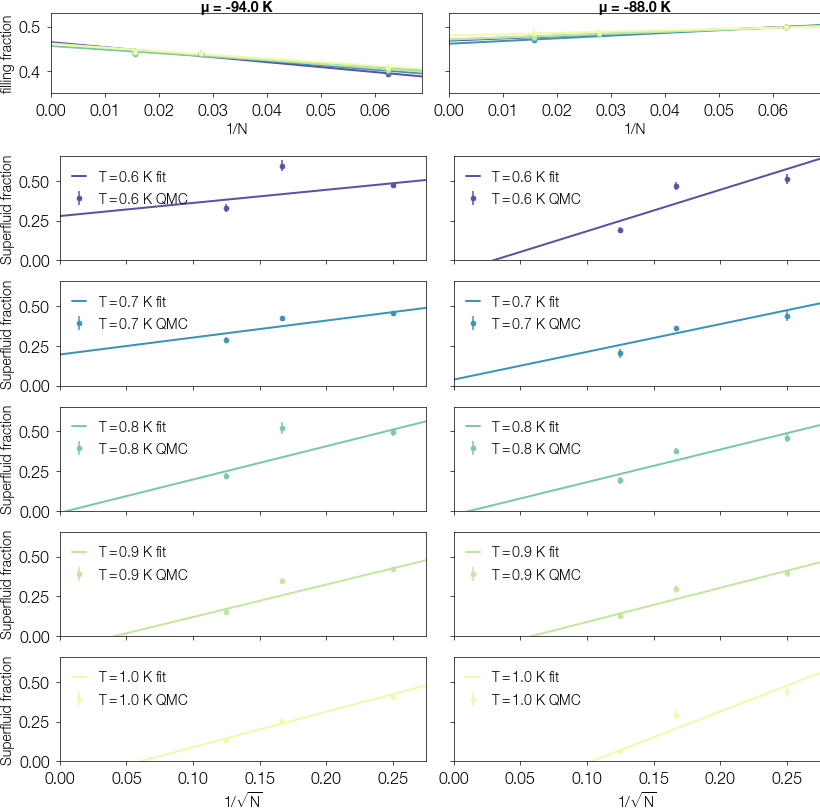

In [8]:
plt.style.reload_library()
dgutils.fonts.set_custom_font(font_path)
_case_key = '0.12,-94.0'
_case_key2 = '0.12,-88.0'
_target = dfdict[_case_key]
_target2 = dfdict[_case_key2]
_plot_target = _target[_target['T']>0.5]
_plot_target2 = _target2[_target2['T']>0.5]

nplot = ptools.plot_only_two_agd(ptools.esti_array_multi(_plot_target),ptools.esti_array_multi(_plot_target2))
nplot.savefig('../figures/figS3.pdf')
nplot.savefig('../figures/figS3.svg')

In [9]:
# If you want to plot data, use below
# plt.style.reload_library()
# dgutils.fonts.set_custom_font(font_path)
# _case_key = '0.12,-94.0'
# _target = dfdict[_case_key]
# _plot_target = _target[_target['T']>0.5]
# _case_name = name_change(_case_key)
# nplot = ptools.plot_only(ptools.esti_array_multi(_plot_target))
# nplot.savefig('../figures/'+_case_name+'.pdf')

In [8]:
# use following functions to SF vs temperature plot of set of keys
def features_T(row):
    
    area = np.sqrt(3)/4*6*1.42
    mass = 10*6.7

    T_lists = [case_out[k]['Tset'] for k in row]
    f_lists = [np.asarray(case_nmean[k])[:,0] for k in row]
    ferr_lists = [np.asarray(case_nerr[k])[:,0] for k in row]
    as_lists = [np.asarray(case_alist[k])[:,0] for k in row]
    as_err_lists = [np.asarray(case_aerrlist[k])[:,0] for k in row]
    rhos_lists = [np.asarray(case_nmean[k])[:,0]*np.asarray(case_alist[k])[:,0]*mass/area for k in row]
    rhos_err_lists = [np.asarray(case_nmean[k])[:,0]*np.asarray(case_aerrlist[k])[:,0]*mass/area for k in row]
    
    return T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists

def final_plot(rows):
    linex = np.linspace(0,1.5,10)
    colmax = max([len(row) for row in rows])
    fig, axs = plt.subplots(colmax,len(rows),sharex=True, sharey=True, figsize=[2*len(rows),(1.8)*colmax])
#     plt.setp(axs, xlim=(0,1.5), ylim=(0.2,0.8))

    for j,row in enumerate(rows):
        T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists = features_T(row)
        
        for i in range(len(row)):
            ax1 = axs[i,j]
            ax2 = ax1.twinx()
#             ax1.errorbar(T_lists[i],rhos_lists[i], yerr = rhos_err_lists[i], 
#                          color = 'brown', label = row[i]+'vs1/sqrt(N)', elinewidth = 5, ecolor = 'grey')
            ax1.errorbar(T_lists[i],as_lists[i], yerr = as_err_lists[i], 
                         color = 'brown', label = row[i]+'vs1/sqrt(N)', elinewidth = 5, ecolor = 'grey')
            ax1.set_ylim(0,1)
            ax1.legend()
#             axs[i,j].plot(linex,7.6/2.2*linex, label = 'KT static theory')
            ax2.errorbar(T_lists[i],f_lists[i], yerr = ferr_lists[i], fmt = '-',
                         color = 'green', elinewidth = 5, ecolor = 'orange')
            ax2.set_ylim(0.2,0.8)
            ax2.tick_params(axis='y', colors='green')
            if row != rows[-1]:
                ax2.set_yticks(np.arange(0.2,0.8,0.1))
                ax2.set_yticklabels(['' for r in np.arange(0.2,0.8,0.1)])
            
#     fig.text(0.5, 0.0, r'T (K)', ha='center', fontsize=12)
#     fig.text(0.0, 0.5, r'SF density$\times 10^{9} \,$ ($\text{g cm}^{-2}$)', 
#              va='center', rotation='vertical', fontsize=12)
#     fig.text(1.0, 0.5, 'filling', va='center', rotation=-90, fontsize=12)
    fig.tight_layout()

# define keys_row1, keys_row2,keys_row3,keys_row4,
#final_plot((keys_row1,keys_row2,keys_row3,keys_row4))

In [9]:
# Find critical temperature
def features_T_each(k):
    
    area = np.sqrt(3)/4*6*1.42
    mass = 10*6.7

    T_lists = case_out[k]['Tset']
    f_lists = np.asarray(case_nmean[k])[:,0]
    ferr_lists = np.asarray(case_nerr[k])[:,0]
    as_lists = np.asarray(case_alist[k])[:,0]
    as_err_lists = np.asarray(case_aerrlist[k])[:,0]
    rhos_lists = np.asarray(case_nmean[k])[:,0]*np.asarray(case_alist[k])[:,0]*mass/area
    rhos_err_lists = np.asarray(case_nmean[k])[:,0]*np.asarray(case_aerrlist[k])[:,0]*mass/area
    
    return T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists

# These are other functions to find Tc, but they are deprecated
def find_Tc(new_x, data):
    Ts = []
    Rs = data[0][::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.1:
            triger = i
            break
    while triger != -1 and stopper == 0:
        checker = 0
        if triger+1 == len(Rs):
            stopper = 1
            break
        for i, v in enumerate(tuple(Rs[triger+1:])):
            if v < 0.1:
                triger += i+1
                break
            else:
                checker += 1
        if checker >= len(Rs)-1-triger:
            stopper = 1
            break
        
                
                
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.1:
            Ts.append(new_x[-1*(i+triger)])
            break
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.2:
            Ts.append(new_x[-1*(i+triger)])
            break
            
    if len(Ts) < 2 :
        return 0  
    else:
        return Ts[0]

def find_Tc_old(new_x, data):
    Ts = []
    Rs = data[0][::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.2:
            Ts.append(new_x[-1*i])
            triger = i
            break
    for i, v in enumerate(tuple(Rs)):
        if v > 1.0:
            Ts.append(new_x[-1*i])
            break
    for i, v in enumerate(tuple(Rs)):
        if v > 1.5:
            Ts.append(new_x[-1*i])
            break
            
    if len(Ts) < 3 :
        return 0
    else:
        return sum(Ts[:-1]) / len(Ts[:-1])
    
def find_root(new_x, Rset):
    Ts = []
    Rs = Rset[::-1]
    triger = -1
    stopper = 0
    for i, v in enumerate(tuple(Rs)):
        if v > 0.01:
            triger = i
            break
    while triger != -1 and stopper == 0:
        checker = 0
        if triger+1 == len(Rs):
            stopper = 1
            break
        for i, v in enumerate(tuple(Rs[triger+1:])):
            if v < 0.01:
                triger += i+1
                break
            else:
                checker += 1
        if checker >= len(Rs)-1-triger:
            stopper = 1
            break
        
                
                
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.01:
            Ts.append(new_x[-1*(i+triger)])
            break
    for i, v in enumerate(tuple(Rs[triger:])):
        if v > 0.1:
            Ts.append(new_x[-1*(i+triger)])
            break
            
    if len(Ts) < 2 :
        return 0  
    else:
        return Ts[0]

In [10]:
featuredata = {}

for k in keylst:
    T_lists, f_lists, ferr_lists, as_lists, as_err_lists, rhos_lists, rhos_err_lists = features_T_each(k)
    new_x = np.linspace(T_lists[0],T_lists[-1],50)
#     f1 = interp1d(T_lists, f_lists)
#     f2 = interp1d(T_lists, rhos_lists)
#     f2 = interp1d(T_lists, as_lists)
    weight = [1/x for x in T_lists]
    f2 = interp1d(T_lists, as_lists)
#     root1 = find_root(new_x, f2(new_x))
    f3 = UnivariateSpline(T_lists, as_lists, w=weight)
    f3.set_smoothing_factor(1.5)
    root2 = f3.roots()
    dev = np.sum(np.sqrt((f2(T_lists) - f3(T_lists))**2/4))
    
    dev *= (sum(T_lists[-2:])-sum(T_lists[:2]))/(sum(as_lists[-2:])-sum(as_lists[:2]))
    dev = np.sqrt(dev**2)*2
    
    featuredata[k] = [f3(new_x), T_lists, f_lists, ferr_lists, 
                      as_lists, as_err_lists, 
                      rhos_lists, rhos_err_lists, f2(new_x), as_lists, dev, root2]

In [11]:
# Finds critical temperature and how much smoothing and actual are different
def find_Tc_new(data):
    Ts = []
    Rs = data[0]
    stdev = data[-2]
    root2 = data[-1]
    # when smooth plot is always above 0 and no root
    if len(root2) == 0:
        if Rs[-1] > 0:
            return 1.0, Rs[-1]
        else:
            return 0, 0
    # roots more than 1, but too low value for lowest temperature
    elif len(root2) > 1:
        if Rs[0] < 0.09:
            return 0, 0
        else:
#             return root2[0], np.sqrt((root2[0]-stdev)**2)
            return root2[0], stdev
    # root exist, but too low value for lowest temperature
    else:
        if Rs[0] < 0.09:
            return 0, 0
        else:
#             return root2[0], np.sqrt((root2[0]-stdev)**2)
            return root2[0], stdev

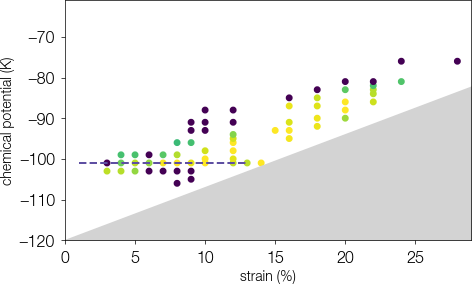

In [12]:
# figure 1: mu-strain w/ Tc phase diagram
mu_s_Tc = []
mu_s_Tc_dev = []
new_x = np.linspace(0.6,1.0,50)

for k in keylst:
#     Tc = find_Tc(new_x, featuredata[k])
    Tc, Tc_dev = find_Tc_new(featuredata[k])
    mu_s_Tc.append(Tc)
    mu_s_Tc_dev.append(Tc_dev)
    

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig1 = plt.figure('fig1') # figsize = [6,4]?
    dgutils.fonts.set_custom_font(font_path)

    ph_x = [float(k.split(',')[0])*100 for k in keylst] # strain
    ph_y = [float(k.split(',')[1]) for k in keylst] # mu

    plt.scatter(ph_x, ph_y, c = np.array(mu_s_Tc), s = 6) # s=20?
    plt.fill_between([0,30], -120 + 1.30*np.array([0,30]), [-120,-120], color = 'lightgray')
    plt.xlim(0,29)
    plt.ylim(-120,-61)
    plt.xlabel('strain (%)') # fontsize = 16?
    plt.ylabel('chemical potential (K)')
    # plt.text(20, -110, 'Vacuum', fontsize = 24)
    plt.hlines(-101.0, 1, 13, ls = '--', lw = 1.0, label = 'next figure')
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
    plt.tight_layout()
    # plt.legend()
    plt.show()

    # Save?
#     fig1.savefig('../figures/Tcs_original.pdf')

In [13]:
# Export dot data?
# np.savetxt("../data/sfdots_x.csv", ph_x, delimiter =", ", fmt='%.12f')
# np.savetxt("../data/sfdots_y.csv", ph_y, delimiter =", ", fmt='%.12f')
# np.savetxt("../data/sfdots_Tc.csv", mu_s_Tc, delimiter =", ", fmt='%.12f')

In [14]:
# figure x: T-rhos w/ mu=-101 slice in diagram
# hkeys = []
# for k in keylst:
#     if k[-6:] == '-101.0':
#         hkeys.append(k)
# fig2 = plt.figure('fig2' ,figsize = [6,4])
# markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
# Tcs = []
# strain = []
# for k in hkeys:
#     Tc = find_Tc(new_x, featuredata[k])
#     Tcs.append(Tc)
#     st = k[:4]
#     st = st.replace(',','0')
#     strain.append(st)

# for i, k in enumerate(hkeys):
#     plt.xlim(0.6, 1.0)
#     plt.ylim(0, 4)
#     xs = featuredata[k][1]
#     xs = np.array(xs)+0.005*(i-3.5)
#     ysl = featuredata[k][0]
#     ys = featuredata[k][-2]
#     yerrs = featuredata[k][-1]
# #     plt.bar(featuredata[k][1], featuredata[k][2], alpha = 0.5)
# #     plt.plot(new_x, ysl,'-')
#     plt.errorbar(xs, ys, yerr=yerrs, 
#                  fmt='.', ecolor=plt.get_cmap('tab10')(i), elinewidth=1, capsize=4, alpha = 0.7
#                 )
# #     plt.scatter(xs, ys, marker = 'd', c = colors[i*-1], s = np.array(yerrs)*1000, alpha = 0.5)
#     plt.plot(xs, ys, markers[i], 
#              color = plt.get_cmap('tab10')(i), mfc='none', 
#              linewidth=1.2, markersize=8, label=f'strain {int(float(strain[i])*100)} \%')
# #     plt.vlines(Tcs[i], 0, 4, color = colors[i*-1])
# plt.legend()
# plt.xlabel('Temperature (K)', fontsize=14)
# plt.ylabel(r'SF density$\times 10^{9} \,$ ($\text{g cm}^{-2}$)', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# plt.show()
# fig2.savefig('newfig2.png')

In [15]:
# colormap tools
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
def mygradient(c1, c2, ratio = 1.0):
    total = 100
    gradnum = int(total*ratio)
    rs = np.linspace(c1[0],c2[0],gradnum)/255
    gs = np.linspace(c1[1],c2[1],gradnum)/255
    bs = np.linspace(c1[2],c2[2],gradnum)/255
    out = [(rs[0],gs[0],bs[0],1) for j in range(total-gradnum)]
    for i in range(gradnum):
        rgb = (rs[i],gs[i],bs[i],1)
        out.append(rgb)
    return out

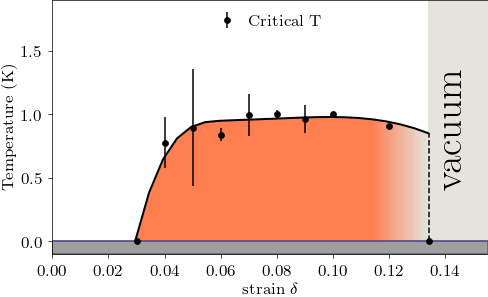

In [16]:
# figure 3: Tc-strain mu = -101 slice in diagram
cut_x = []
cut_y = []
cut_y_dev = []

for x, y, Tc, Tc_dev in zip(ph_x, ph_y, np.array(mu_s_Tc), np.array(mu_s_Tc_dev)):
    if y == -101.0 and int(x) != 14:
        cut_x.append(x)
        cut_y.append(Tc)
        cut_y_dev.append(Tc_dev)
        
f_Tc = UnivariateSpline(cut_x, cut_y)
f_Tc.set_smoothing_factor(0.03)
# new_x = np.linspace(0.03,0.1,20)
# new_x2 = np.arange(3,14.1,0.5)
# new_x3 = np.arange(3,13.4,0.5)
new_x3 = np.linspace(2.95,13.4,22)

coral = [255,127,80]
# coldgrey = [168,178,175]
warmgrey = [230, 226, 220] #e6e2dc
mycmaplist = mygradient(coral, warmgrey, ratio = 0.2)
mycmap = mcolors.ListedColormap(mycmaplist)

cut_x_new = np.array(cut_x[:-1]+[13.4,])/100
cut_y_new = np.array(cut_y[:-1]+[0,])

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig3 = plt.figure('fig3', constrained_layout=True) # figsize = [4,3]
#    dgutils.fonts.set_custom_font(font_path)
    
    sfregime = plt.fill_between(new_x3/100, f_Tc(new_x3), color='none')
    
    verts = np.vstack([p.vertices for p in sfregime.get_paths()])
    gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
                          extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
    gradient.set_clip_path(sfregime.get_paths()[0], transform=plt.gca().transData)
    
    plt.fill_between([13.4/100,15.5/100], [2,2], color=mycmaplist[-1])
    pline = plt.plot(new_x3/100, f_Tc(new_x3), 'k-', linewidth=1.0, )
    plt.errorbar(cut_x_new, cut_y_new, 
                 ms = 6, mfc = 'k',
                 yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = 'Critical T')
    plt.axhline(y=0)
    plt.fill_between([0, 15.5/100], 0, -0.1, color="#414141", alpha = 0.5)
    plt.xlabel('strain '+r'$\delta$', ) #fontsize=14
    plt.ylabel('Temperature (K)', ) #fontsize=14
    plt.xlim(0,15.5/100)
    plt.ylim(-0.1, 1.9)
#     plt.axis('off')
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    plt.legend(loc = 'upper center', ) #fontsize = 12
    plt.vlines(13.4/100, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
    fig3.text(0.88, 0.39, 'vacuum', fontsize=20, color='k', rotation = 90)
#     plt.tight_layout()
    plt.show()

    # save?
    # fig3.savefig('../figures/Tc_cut.pdf')

In [17]:
# cut2_x = []
# cut2_y = []
# cut2_y_dev = []

# for x, y, Tc, Tc_dev in zip(ph_x, ph_y, np.array(mu_s_Tc), np.array(mu_s_Tc_dev)):
#     if x == 12.0:
#         cut2_x.append(y)
#         cut2_y.append(Tc)
#         cut2_y_dev.append(Tc_dev)
        
# plt.errorbar(cut2_x, cut2_y, fmt='o-', yerr=cut2_y_dev, )

# To determine the phase boundary, we use 0.6K data

<ipython-input-18-e365713a712e>:29: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig3.colorbar(pts)


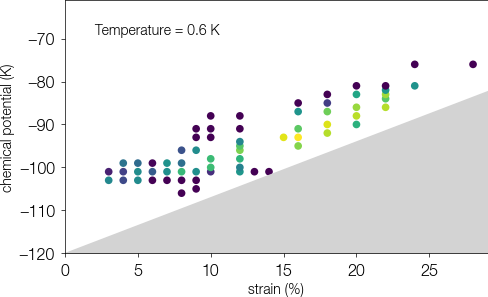

In [18]:
# Generate dot data for later use
# figure 4: mu-strain at T=0.6K w/ rhos phase diagram
mu_s_rhos = []

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig4 = plt.figure('fig4' , constrained_layout=True) #figsize = [6,4]
    dgutils.fonts.set_custom_font(font_path)

    ph_x = [float(k.split(',')[0])*100 for k in keylst] # strain
    ph_y = [float(k.split(',')[1]) for k in keylst] # mu

    for k in keylst:
        Ts = featuredata[k][1]
        loc = np.where(np.array(Ts) == 0.6)
        val = float(featuredata[k][6][loc])
        if val < 0:
            val = 0
        mu_s_rhos.append(float(val))

    pts = plt.scatter(ph_x, ph_y, c = np.array(mu_s_rhos), s=8) #s = 20
    plt.fill_between([0,30], -120 + 1.30*np.array([0,30]), [-120,-120], color = 'lightgray')
    plt.xlim(0,29)
    plt.ylim(-120,-61)
    plt.xlabel('strain (%)', ) #fontsize=16
    plt.ylabel('chemical potential (K)', ) #fontsize=16
    # plt.text(20, -110, 'Vacuum', fontsize = 24)
    # plt.hlines(-101.0, 1, 13, ls = '--', lw = 1.0, label = 'next figure')
    cbar = fig3.colorbar(pts)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
    fig4.text(0.2, 0.87, 'Temperature = 0.6 K', color='black') #, fontsize=14
#     plt.tight_layout()
    # plt.legend()
    plt.show()

    # save?
#     fig4.savefig('../figures/SFs_at_lowT.pdf')

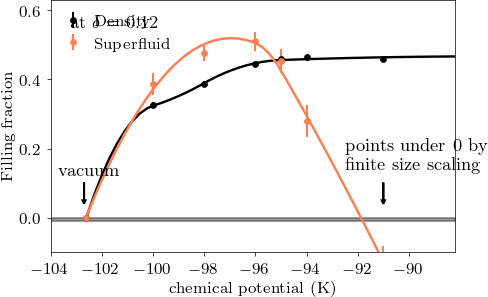

In [19]:
# figure 5: f-mu strain 12% slice in diagram
vkeys = []
for k in keylst:
    if k[:4] == '0.12':
        vkeys.append(k)
vkeys = vkeys[1:]

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig5 = plt.figure('fig5' , constrained_layout=True) #figsize = [4,3]
#    dgutils.fonts.set_custom_font(font_path)
    
    markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
    mus = [float(k.split(',')[1]) for k in vkeys]
    mus.insert(0, -102.6)
    fr = [0,]
    frerr = [0,]
    sfr = [0,]
    sfrerr = [0,]
    for k in vkeys:
        Ts = featuredata[k][1]
        loc = np.where(np.array(Ts) == 0.6)
        fr_i = float(featuredata[k][2][loc])
        frerr_i = float(featuredata[k][3][loc])
        sfr_i = float(featuredata[k][4][loc])
        sfrerr_i = float(featuredata[k][5][loc])
        fr.append(fr_i)
        frerr.append(frerr_i)
        sfr.append(sfr_i)
        sfrerr.append(sfrerr_i)
    
    plt.xlim(-104, -88.2)
    plt.ylim(-0.1, 0.63)
    plt.fill_between([-104, -88.2], 0, -0.01, color="#414141", alpha = 0.5)
    
    f_fc = UnivariateSpline(np.array(mus), np.array(fr), k=2)
    f_fc.set_smoothing_factor(0.0001)
    f_sfc = UnivariateSpline(np.array(mus), np.array(sfr), k=2)
    f_sfc.set_smoothing_factor(0.002)
    new_mus = np.linspace(mus[0]-0.00,mus[-1],50)
    plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
    plt.plot(new_mus, f_sfc(new_mus), '-', color='coral' , linewidth=1.2)

    # plt.scatter(np.array(mus), np.array(fr), s=50, marker='o', color = 'k', facecolors='none', label = 'Density')
    plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
                fmt='.',ms = 6, elinewidth=1, label='Density', color='k')
    plt.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
                fmt='.',ms = 6, elinewidth=1, label='Superfluid', color='coral')
    
    plt.xlabel('chemical potential (K)',) # fontsize=14
    plt.ylabel('Filling fraction',) # fontsize=14
    plt.legend()
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    # plt.vlines(-91.8, 0, 0.2)
#     plt.tight_layout()
    fig5.text(0.15, 0.89, r'at $\delta=0.12$', color='black') #  fontsize=12
    plt.arrow(mus[0]-0.09, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
    plt.text(-103.7, 0.12, "vacuum")
    plt.arrow(-91, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
    plt.arrow(-88, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
    plt.text(-92.5, 0.14, "points under 0 by\n finite size scaling")
    plt.show()

    # save?
#     fig5.savefig('../figures/lowT_strain12.pdf')


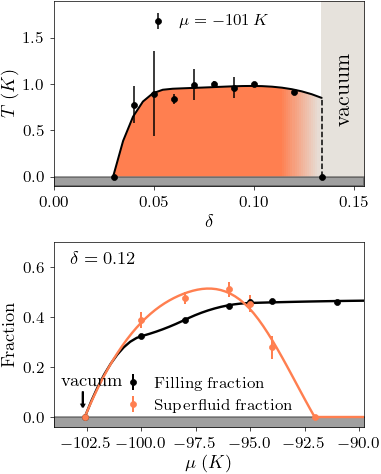

In [23]:
mosaic = """
A
B
"""

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig_stack = plt.figure(constrained_layout=True , figsize = (3.4039020340390205*0.8, 2.1037271514110163*2*0.8)) # figsize = [4,3] or 3.4646, 2.14122
    ax_dict = fig_stack.subplot_mosaic(mosaic)
#    dgutils.fonts.set_custom_font(font_path)
    font_props = dgutils.fonts.get_custom_font_props(bold_font_path)
    
    ax1 = ax_dict["A"]
    plt.sca(ax1)
    sfregime = plt.fill_between(new_x3/100, f_Tc(new_x3), color='none')
    
    verts = np.vstack([p.vertices for p in sfregime.get_paths()])
    gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
                          extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
    gradient.set_clip_path(sfregime.get_paths()[0], transform=plt.gca().transData)
    
    plt.fill_between([13.4/100,15.5/100], [2,2], color=mycmaplist[-1])
    pline = plt.plot(new_x3/100, f_Tc(new_x3), 'k-', linewidth=1.0, )
    plt.errorbar(cut_x_new, cut_y_new, 
                 ms = 6, mfc = 'k',
                 yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = r'$\mu=-101\,K$')
#     plt.axhline(y=0)
    plt.fill_between([0, 15.5/100], 0, -0.1, color="#414141", alpha = 0.5)
    plt.xlabel(r'$\delta$', fontsize=9) #fontsize=14
    plt.ylabel(r'$T\; (K)$', fontsize=9) #fontsize=14
    plt.xlim(0,15.5/100)
    plt.ylim(-0.1, 1.9)
#     plt.axis('off')
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
    plt.legend(loc = 'upper center', ) #fontsize = 12
    plt.vlines(13.4/100, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
    ax1.text(0.908, 0.34, 'vacuum',transform=ax1.transAxes, fontsize=11, color='k', rotation = 90,)
#     ax1.text(-0.12,1.0,'(a)', ha='left',va='top', transform=ax1.transAxes, fontproperties=font_props)
    ##############################
    ax2 = ax_dict["B"]
    plt.sca(ax2)
    
    plt.xlim(-104, -89.8)
    plt.ylim(-0.04, 0.7)
    plt.fill_between([-104, -88.2], 0, -0.19, color="#414141", alpha = 0.5)
#     plt.axhline(0, color='k')
    
    f_fc = UnivariateSpline(np.array(mus), np.array(fr), k=2)
    f_fc.set_smoothing_factor(0.0001)
    f_sfc = UnivariateSpline(np.array(mus), np.array(sfr), k=3)
    f_sfc.set_smoothing_factor(0.002)
    try: 
        sfc_root = f_sfc.roots()[0]
        if sfc_root:
            new_mus = np.linspace(mus[0],mus[-1],50)
            new_mus_1 = np.linspace(mus[0],sfc_root,50)
            new_mus_2 = np.linspace(sfc_root,mus[-1],50)
            plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
            plt.plot(new_mus_1, f_sfc(new_mus_1), '-', color='coral' , linewidth=1.2)
#             plt.plot(new_mus_2, f_sfc(new_mus_2), '--', color='coral' , linewidth=1.2)
            plt.plot(new_mus_2, np.zeros(len(new_mus_2)), '-', color='coral' , linewidth=1.2)
            plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
                    fmt='.',ms = 6, elinewidth=1, label='Filling fraction', color='k')
            plt.errorbar(np.array(mus[:-2]+[sfc_root,]), np.array(sfr[:-2]+[0,]), 
                         yerr = np.array(sfrerr[:-2]+[0,]),
                        fmt='.',ms = 6, elinewidth=1, label='Superfluid fraction', color='coral')
#             plt.arrow(sfc_root, 0.12, 0, -0.05, head_width=0.12, head_length=0.01)
#             plt.text(sfc_root-0.9, 0.16, r"T$_{c}$"+" below 0.6 K")
    except:    
        new_mus = np.linspace(mus[0],mus[-1],50)
        plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
        plt.plot(new_mus, f_sfc(new_mus), '-', color='coral' , linewidth=1.2)
        plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
                    fmt='.',ms = 6, elinewidth=1, label='Density', color='k')
        plt.errorbar(np.array(mus), np.array(sfr[:-2]+[0,0]), yerr = np.array(sfrerr[:-2]+[0,0]),
                    fmt='.',ms = 6, elinewidth=1, label='Superfluid', color='coral')
    
    plt.xlabel(r'$\mu\;(K)$',fontsize=9) # fontsize=14
    plt.ylabel('Fraction',fontsize=9) # fontsize=14
    plt.legend()
    plt.arrow(mus[0]-0.09, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
    plt.text(-103.7, 0.12, "vacuum")
    ax2.text(0.05, 0.88, r'$\delta=0.12$',transform=ax2.transAxes, color='black')
#     ax2.text(-0.12,1.0,'(b)', ha='left',va='top', transform=ax2.transAxes, fontproperties=font_props)
    
    fig_stack.savefig('../figures/fig3_insets2.pdf')
#     fig_stack.savefig('../figures/fig4.svg')

In [21]:
# mosaic = """
# A
# B
# """

# plt.style.reload_library()
# with plt.style.context(plot_style['aps']):
#     fig_stack = plt.figure(constrained_layout=True , figsize = (3.4039020340390205, 2.1037271514110163*2)) # figsize = [4,3] or 3.4646, 2.14122
#     ax_dict = fig_stack.subplot_mosaic(mosaic)
# #    dgutils.fonts.set_custom_font(font_path)
#     font_props = dgutils.fonts.get_custom_font_props(bold_font_path)
    
#     ax1 = ax_dict["A"]
#     plt.sca(ax1)
#     sfregime = plt.fill_between(new_x3/100, f_Tc(new_x3), color='none')
    
#     verts = np.vstack([p.vertices for p in sfregime.get_paths()])
#     gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
#                           extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
#     gradient.set_clip_path(sfregime.get_paths()[0], transform=plt.gca().transData)
    
#     plt.fill_between([13.4/100,15.5/100], [2,2], color=mycmaplist[-1])
#     pline = plt.plot(new_x3/100, f_Tc(new_x3), 'k-', linewidth=1.0, )
#     plt.errorbar(cut_x_new, cut_y_new, 
#                  ms = 6, mfc = 'k',
#                  yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = r'$\mu\,/\,k_{\rm B}=-101\,K$')
# #     plt.axhline(y=0)
#     plt.fill_between([0, 15.5/100], 0, -0.1, color="#414141", alpha = 0.5)
#     plt.xlabel('strain '+r'$\delta$', ) #fontsize=14
#     plt.ylabel('Critical Temperature (K)', ) #fontsize=14
#     plt.xlim(0,15.5/100)
#     plt.ylim(-0.1, 1.9)
# #     plt.axis('off')
# #     plt.xticks(fontsize=10)
# #     plt.yticks(fontsize=10)
#     plt.legend(loc = 'upper center', ) #fontsize = 12
#     plt.vlines(13.4/100, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
#     ax1.text(0.908, 0.34, 'vacuum',transform=ax1.transAxes, fontsize=11, color='k', rotation = 90,)
#     ax1.text(-0.12,1.0,'(a)', ha='left',va='top', transform=ax1.transAxes, fontproperties=font_props)
#     ##############################
#     ax2 = ax_dict["B"]
#     plt.sca(ax2)
    
#     plt.xlim(-104, -89.8)
#     plt.ylim(-0.04, 0.7)
#     plt.fill_between([-104, -88.2], 0, -0.19, color="#414141", alpha = 0.5)
# #     plt.axhline(0, color='k')
    
#     f_fc = UnivariateSpline(np.array(mus), np.array(fr), k=2)
#     f_fc.set_smoothing_factor(0.0001)
#     f_sfc = UnivariateSpline(np.array(mus), np.array(sfr), k=3)
#     f_sfc.set_smoothing_factor(0.002)
#     try: 
#         sfc_root = f_sfc.roots()[0]
#         if sfc_root:
#             new_mus = np.linspace(mus[0],mus[-1],50)
#             new_mus_1 = np.linspace(mus[0],sfc_root,50)
#             new_mus_2 = np.linspace(sfc_root,mus[-1],50)
#             plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
#             plt.plot(new_mus_1, f_sfc(new_mus_1), '-', color='coral' , linewidth=1.2)
# #             plt.plot(new_mus_2, f_sfc(new_mus_2), '--', color='coral' , linewidth=1.2)
#             plt.plot(new_mus_2, np.zeros(len(new_mus_2)), '-', color='coral' , linewidth=1.2)
#             plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
#                     fmt='.',ms = 6, elinewidth=1, label='Filling fraction', color='k')
#             plt.errorbar(np.array(mus[:-2]+[sfc_root,]), np.array(sfr[:-2]+[0,]), 
#                          yerr = np.array(sfrerr[:-2]+[0,]),
#                         fmt='.',ms = 6, elinewidth=1, label='Superfluid fraction', color='coral')
# #             plt.arrow(sfc_root, 0.12, 0, -0.05, head_width=0.12, head_length=0.01)
# #             plt.text(sfc_root-0.9, 0.16, r"T$_{c}$"+" below 0.6 K")
#     except:    
#         new_mus = np.linspace(mus[0],mus[-1],50)
#         plt.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
#         plt.plot(new_mus, f_sfc(new_mus), '-', color='coral' , linewidth=1.2)
#         plt.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
#                     fmt='.',ms = 6, elinewidth=1, label='Density', color='k')
#         plt.errorbar(np.array(mus), np.array(sfr[:-2]+[0,0]), yerr = np.array(sfrerr[:-2]+[0,0]),
#                     fmt='.',ms = 6, elinewidth=1, label='Superfluid', color='coral')
    
#     plt.xlabel('chemical potential (K)',) # fontsize=14
#     plt.ylabel('Fraction',) # fontsize=14
#     plt.legend()
#     plt.arrow(mus[0]-0.09, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
#     plt.text(-103.7, 0.12, "vacuum")
#     ax2.text(0.05, 0.88, r'$\delta=0.12$',transform=ax2.transAxes, color='black')
#     ax2.text(-0.12,1.0,'(b)', ha='left',va='top', transform=ax2.transAxes, fontproperties=font_props)
    
#     fig_stack.savefig('../figures/fig4.pdf')
#     fig_stack.savefig('../figures/fig4.svg')

In [23]:
# fig = plt.figure(constrained_layout=True)
# ax_dict = fig.subplot_mosaic(mosaic)
# mosaic = """
# A
# B
# """

# plt.style.reload_library()
# with plt.style.context(plot_style['sans']):
#     fig_stack = plt.figure(constrained_layout=True , figsize = (3.4646, 2.14122*2)) # figsize = [4,3] or 3.4646, 2.14122
#     ax_dict = fig_stack.subplot_mosaic(mosaic)
#     dgutils.fonts.set_custom_font(font_path)
#     font_props = dgutils.fonts.get_custom_font_props(bold_font_path)
    
#     ax1 = ax_dict["A"]
    
#     sfregime = ax1.fill_between(new_x3/100, f_Tc(new_x3), color='none')
    
#     verts = np.vstack([p.vertices for p in sfregime.get_paths()])
#     gradient = ax1.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=mycmap, aspect='auto',
#                           extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
#     gradient.set_clip_path(sfregime.get_paths()[0], transform=ax1.transData)
    
#     ax1.fill_between([13.4/100,15.5/100], [2,2], color=mycmaplist[-1])
#     pline = ax1.plot(new_x3/100, f_Tc(new_x3), 'k-', linewidth=1.0, )
#     ax1.errorbar(cut_x_new, cut_y_new, 
#                  ms = 4, mfc = 'k',
#                  yerr = cut_y_dev[:-1]+[0,], fmt='.', color = 'k', label = 'Critical T')

#     ax1.set_xlabel('strain '+r'$\delta$', ) #fontsize=14
#     ax1.set_ylabel('Temperature (K)', ) #fontsize=14
#     ax1.set_xlim(0,15.5/100)
#     ax1.set_ylim(0, 1.9)
# #     plt.xticks(fontsize=10)
# #     plt.yticks(fontsize=10)
#     ax1.legend(loc = 'upper center', ) #fontsize = 12
#     ax1.vlines(13.4/100, 0, f_Tc(13.4), linestyles ="dashed", colors ="k")
#     ax1.text(0.908, 0.34, 'vacuum',transform=ax1.transAxes, fontsize=11, color='k', rotation = 90,)
#     ax1.text(-0.14,1.0,'a', ha='left',va='top', transform=ax1.transAxes, fontproperties=font_props)
    
#     ###########################################
#     ax2 = ax_dict["B"]
    
#     ax2.set_xlim(-103, -88.2)
#     ax2.set_ylim(0, 0.63)
    
#     ax2.plot(new_mus, f_fc(new_mus), 'k-', linewidth=1.2)
#     ax2.plot(new_mus, f_sfc(new_mus), '-', color = 'coral', linewidth=1.2)

#     # plt.scatter(np.array(mus), np.array(fr), s=50, marker='o', color = 'k', facecolors='none', label = 'Density')
#     ax2.errorbar(np.array(mus), np.array(fr), yerr = np.array(frerr),
#                 fmt='.',ms = 4, elinewidth=1, label='Density', color='k')
#     ax2.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
#                 fmt='.',ms = 4, elinewidth=1, label='Superfluid', color='coral')

#     ax2.set_xlabel('chemical potential (K)',) # fontsize=14
#     ax2.set_ylabel('Filling fraction',) # fontsize=14
#     ax2.legend()

#     ax2.text(0.1, 0.87, r'strain $\delta$ = 0.12',transform=ax2.transAxes, color='black') #  fontsize=12
#     ax2.text(-0.14,1.0,'b', ha='left',va='top', transform=ax2.transAxes, fontproperties=font_props)
    
#     plt.arrow(mus[0]-0.09, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
#     plt.text(-103.7, 0.12, "vacuum")
#     plt.arrow(-91, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
#     plt.arrow(-88, 0.1, 0, -0.05, head_width=0.12, head_length=0.01)
#     plt.text(-92.5, 0.14, "points under 0 by\n finite size scaling")
#     plt.show()
# #     plt.tight_layout()
#     plt.show()
    
#     fig_stack.savefig('../figures/fig4.pdf')

# Finding upper bound
Below codes are hard coded

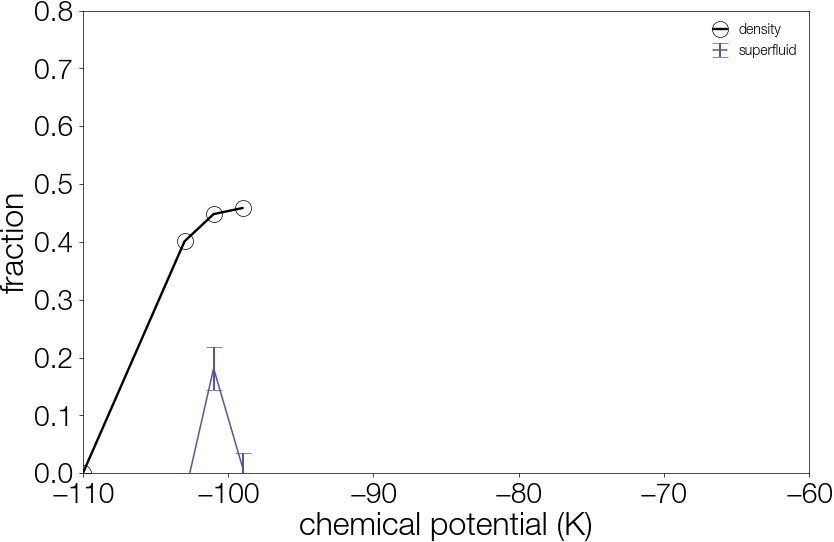

In [97]:
# Find boundary SF vanish
guess = -85.7

vkeys = []
for k in keylst:
    if k[:4] == '0.06':
        vkeys.append(k)

fig5 = plt.figure('fig5' ,figsize = [6,4])
markers = ['ko-', 'ko-', 'ks-', 'k*-', 'kD-', 'kp-', 'kP-']
mus = [float(k.split(',')[1]) for k in vkeys]
mus.insert(0, -110)
fr = [0,]
sfr = [0,]
sfrerr = [0,]
for k in vkeys:
    Ts = featuredata[k][1]
    loc = np.where(np.array(Ts) == 0.6)
    fr_i = float(featuredata[k][2][loc])
    sfr_i = float(featuredata[k][4][loc])
    sfrerr_i = float(featuredata[k][5][loc])
    fr.append(fr_i)
    sfr.append(sfr_i)
    sfrerr.append(sfrerr_i)

plt.xlim(-110, -60)
plt.ylim(0, 0.8)
plt.plot(np.array(mus), np.array(fr), 'ko-',
        mfc='none', linewidth=1.2, markersize=8, label='density')
plt.errorbar(np.array(mus), np.array(sfr), yerr = np.array(sfrerr),
            fmt='-', elinewidth=1, capsize=4, label='superfluid')

plt.xlabel('chemical potential (K)', fontsize=16)
plt.ylabel('fraction', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.vlines(guess, 0, 0.2)
plt.tight_layout()
# fig5.text(0.13, 0.87, 'at 12\% strain', fontsize=14, color='black')

plt.show()

# save?
# fig5.savefig('newfig5.png')

# Following field is for resubmission codes.
## It read 'log' file for continue simulation and make slurm cmd file

In [ ]:
# Make target dataframe for submission
# Example:
target = dbase[(dbase['mu'] == -101.0)&(dbase['estsize'] < 4000)]
print('target df length is: ',len(target))

In [ ]:
# Current date
date = 'May09'
# Filename, date, suffix
gensub.continue_from(target, 'pimc_cont', date, suffix = 0)